In [1]:
import vtk
from vtk.util import numpy_support
import numpy as np

In [2]:
def vtk_to_numpy(vtk_file):
    # Read the VTK file
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the VTK data
    vtk_data = reader.GetOutput()

    # Extract the volume as a NumPy array
    dimensions = vtk_data.GetDimensions()
    vtk_array = vtk_data.GetPointData().GetScalars()
    numpy_array = numpy_support.vtk_to_numpy(vtk_array)
    
    # Reshape the array to match the original dimensions
    numpy_array = numpy_array.reshape(dimensions, order='F')  # 'F' for Fortran order
    return numpy_array


In [3]:
from skimage.morphology import skeletonize

# Load the VTK file and convert to NumPy array
vtk_file = 'volume.vtk'
volume = vtk_to_numpy(vtk_file)

# Ensure the volume is binary (for skeletonization)
binary_volume = volume > 0  # Adjust the threshold if necessary

# Apply 3D skeletonization
skeleton = skeletonize(binary_volume)

In [4]:
import numpy as np

# Save the skeletonized volume as a .npy file
np.save('skeleton.npy', skeleton)

c:\Users\nerea\anaconda3\envs\SCenv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vuetify' from 'trame.widgets' (c:\Users\nerea\anaconda3\envs\SCenv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


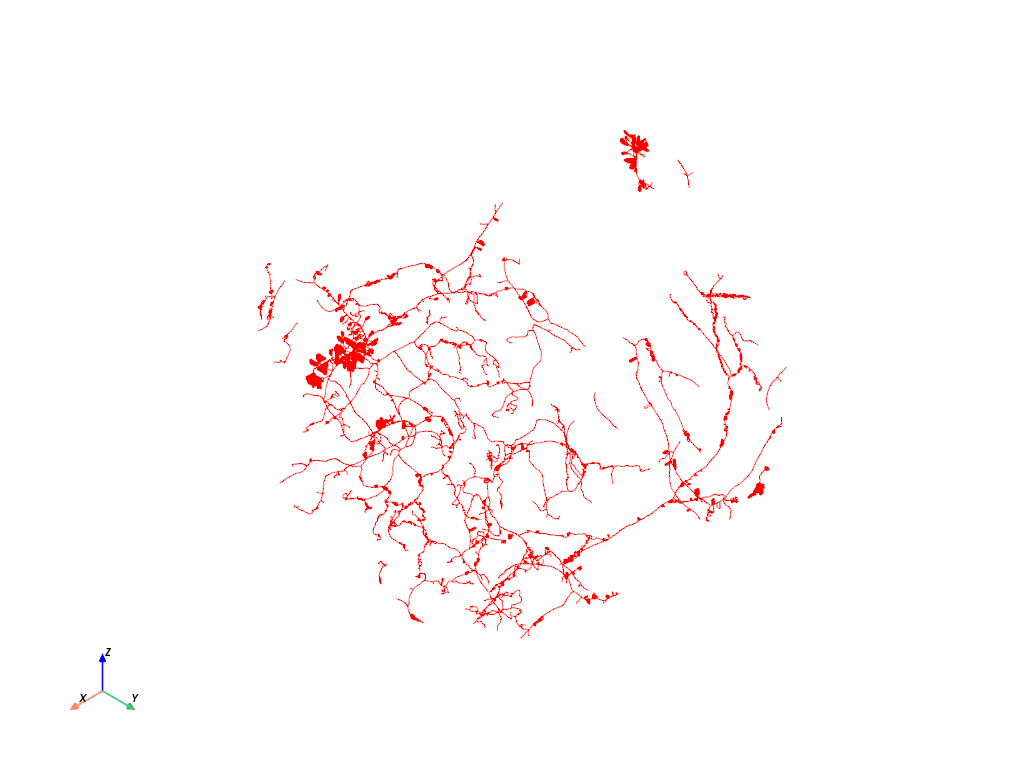

In [15]:
import pyvista as pv
import numpy as np
from pyvista import set_jupyter_backend

# Assuming 'skeleton' is your skeletonized numpy array from earlier
def visualize_3d_skeleton(skeleton):
    # Create a pyvista grid from the skeleton
    # PyVista expects the skeleton in (x, y, z) format, so we transpose the array
    points = np.argwhere(skeleton).astype(np.float32)  # Cast to np.float32

    # Create a point cloud from the skeleton points
    cloud = pv.PolyData(points)

    # Create a pyvista plotter object
    plotter = pv.Plotter()

    # Add the point cloud to the plotter
    plotter.add_mesh(cloud, color='red', point_size=1)

    # Add some labels or axis if you like
    plotter.add_axes()

    # Show the plot
    plotter.show()

# Visualize the 3D skeleton
visualize_3d_skeleton(skeleton)